In [1]:

import numpy as np
import tensorflow as tf

NUMBER_OF_CLASSES=5
template_features = np.genfromtxt('../data/interim/template_matching.csv', skip_header=True, dtype=float, delimiter=',')
gabriel_features = np.genfromtxt('../data/processed/combined_features.csv', skip_header=True, dtype=float, delimiter=',')
print('labels do match?', all(template_features[:, 0] == gabriel_features[:, 0]))
y = tf.one_hot(indices=template_features[:,0], depth=NUMBER_OF_CLASSES).numpy()
X = np.hstack((template_features[:,1:], gabriel_features[:,1:]))

X = X / X.max(axis=0) # alongside rows, per column

print(X.shape, y.shape)
number_of_features = X.shape[1]


labels do match? True
(10000, 205) (10000, 5)


In [2]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

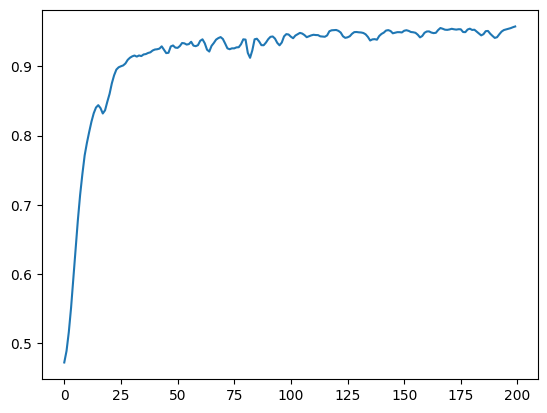

np.float64(0.9578867034954014)

In [ ]:


def softmax(v: np.array):
    v_max = np.max(v, axis=1)[:, np.newaxis]
    exp = np.exp(v - v_max) 
    return exp / np.sum(exp, axis=1)[:, np.newaxis]


def cross_entropy(y: np.array, a_o: np.array):
    # numerical stability
    epsilon = 1e-12
    a_o = np.clip(a_o, epsilon, 1. - epsilon)
    return -np.mean(np.sum(y * np.log(a_o), axis=1))

def softmax_cross_entropy2deriv(y, output):
    """I'm comput dL/da * da/dz in one step in order to avoid tinkering with jacobi of softmax"""
    return (output-y)/len(y)
 
def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoid2deriv(output):
    return output*(1-output)

def relu(x):
    return (x>0)*x
def relu2deriv(output):
    return output > 0

hidden_size_1=128
hidden_size_2=128
hidden_size_3=128
output_size=5
alpha=0.1
beta=0.1

# using glorot and he initialization to omit symmetry problem
lol = []
weights_0_1 = np.random.randn(X.shape[1], hidden_size_1) * np.sqrt(2 / X.shape[1])
weights_1_2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2 / hidden_size_1)
weights_2_3 = np.random.randn(hidden_size_2, hidden_size_3) * np.sqrt(2 / hidden_size_2)
weights_3_4 = np.random.randn(hidden_size_3, output_size) * np.sqrt(2 / (hidden_size_3+y.shape[1]))

# just constants
biases_1 = np.zeros((1, hidden_size_1))
biases_2 = np.zeros((1, hidden_size_2))
biases_3 = np.zeros((1, hidden_size_3))
biases_4 = np.zeros((1, y.shape[1]))

from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

weights_0_1_gradient, weights_1_2_gradient, weights_2_3_gradient, weights_3_4_gradient = (0, 0, 0, 0)
weights_0_1_gradient, weights_1_2_gradient, weights_2_3_gradient, weights_3_4_gradient = (0, 0, 0, 0)
# better naming - like velocity and gradient_after_velocity
for _ in range(200):
    idx = np.random.choice(X_train.shape[0], 32, replace=False)
    labels=y_train[idx]
    layers_0 = X_train[idx]
    layers_1 = relu(layers_0 @ weights_0_1 + biases_1) 
    layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
    layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
    layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
    
    # print(cross_entropy(labels, layers_4))
    
    layers_4_delta = softmax_cross_entropy2deriv(labels, layers_4) # we combine dL/dz * dz/a
    layers_3_delta = layers_4_delta @ weights_3_4.T * relu2deriv(layers_3)
    layers_2_delta = layers_3_delta @ weights_2_3.T * relu2deriv(layers_2)
    layers_1_delta = layers_2_delta @ weights_1_2.T * relu2deriv(layers_1) 
    
    # we can add and add them.

    
    weights_3_4_gradient += alpha*(layers_3.T @ layers_4_delta)
    weights_2_3_gradient += alpha*(layers_2.T @ layers_3_delta)
    weights_1_2_gradient += alpha*(layers_1.T @ layers_2_delta)
    weights_0_1_gradient += alpha*(layers_0.T @ layers_1_delta)

    biases_4-= alpha*layers_4_delta.sum(axis=0)
    biases_3-= alpha*layers_3_delta.sum(axis=0)
    biases_2-= alpha*layers_2_delta.sum(axis=0)
    biases_1-= alpha*layers_1_delta.sum(axis=0)
    
    
    weights_3_4-= beta*weights_3_4_gradient
    weights_2_3-= beta*weights_2_3_gradient
    weights_1_2-= beta*weights_1_2_gradient
    weights_0_1-= beta*weights_0_1_gradient

    layers_1 = relu(X_val @ weights_0_1 + biases_1) 
    layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
    layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
    layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
    # THIS is the exact same way that Keras default AUC (which we use in reference) is computed!
    x = roc_auc_score(y_val, layers_4, multi_class='ovr', average='macro')
    lol.append(x)
plt.figure()
plt.plot(lol)
plt.show()
x